## Assignment 4

Import Important Python Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Import dataset as pdata

In [3]:
pdata=pd.read_csv("time_series_ass3.csv")

Understanding the data

In [4]:
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          8640 non-null   int64  
 1   From                8640 non-null   object 
 2   To (Interval: 15M)  8640 non-null   object 
 3   PM10 (µg/m3)        6959 non-null   float64
 4   PM2.5 (µg/m3)       8414 non-null   float64
 5   NO (µg/m3)          7271 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 405.1+ KB


In [5]:
pdata.head()

,Unnamed: 0,From,To (Interval: 15M),PM10 (µg/m3),PM2.5 (µg/m3),NO (µg/m3)
0,0,2023-02-01 00:00:00,2023-02-01 00:15:00,95.0,35.0,NaN
1,1,2023-02-01 00:15:00,2023-02-01 00:30:00,95.0,35.0,NaN
2,2,2023-02-01 00:30:00,2023-02-01 00:45:00,95.0,35.0,NaN
3,3,2023-02-01 00:45:00,2023-02-01 01:00:00,122.0,34.0,NaN
4,4,2023-02-01 01:00:00,2023-02-01 01:15:00,122.0,34.0,NaN


In [6]:
pdata.tail()

,Unnamed: 0,From,To (Interval: 15M),PM10 (µg/m3),PM2.5 (µg/m3),NO (µg/m3)
8635,8635,2023-05-01 22:45:00,2023-05-01 23:00:00,19.0,11.0,17.9
8636,8636,2023-05-01 23:00:00,2023-05-01 23:15:00,19.0,11.0,17.9
8637,8637,2023-05-01 23:15:00,2023-05-01 23:30:00,19.0,11.0,19.6
8638,8638,2023-05-01 23:30:00,2023-05-01 23:45:00,19.0,11.0,20.8
8639,8639,2023-05-01 23:45:00,2023-05-02 00:00:00,32.0,6.0,21.8


<Axes: >

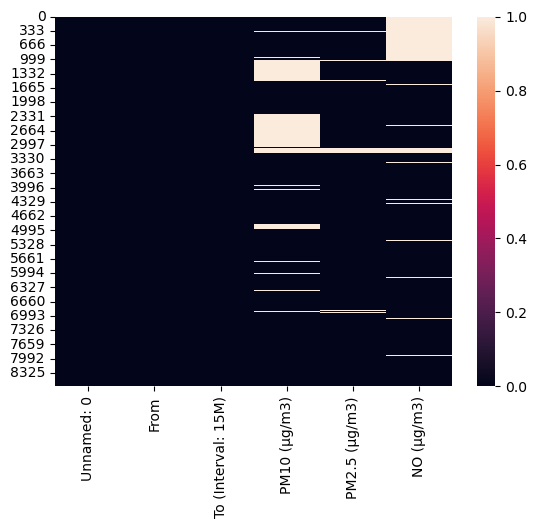

In [7]:
sns.heatmap(pdata.isnull())

**Preparing the Data**

Handling Outliers

In [8]:
def outl(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = np.where((data < lower_bound) | (data > upper_bound), np.nan, data)
    return data

In [9]:
pdata['NO (µg/m3)']=outl(pdata['NO (µg/m3)'])
pdata['PM10 (µg/m3)']=outl(pdata['PM10 (µg/m3)'])
pdata['PM2.5 (µg/m3)']=outl(pdata['PM2.5 (µg/m3)'])

In [10]:
pdata['NO (µg/m3)']=pdata['NO (µg/m3)'].interpolate(method='linear')
pdata['PM10 (µg/m3)']=pdata['PM10 (µg/m3)'].interpolate(method='linear')
pdata['PM2.5 (µg/m3)']=pdata['PM2.5 (µg/m3)'].interpolate(method='linear')

Predicting the missing values using ARIMA

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
def predict_missing_values(data, forecast_length):
    ob = data.dropna()
    mi = data[data.isna()]
    model = ARIMA(ob, order=(1, 1, 1))
    model_fit = model.fit()
    
    
    predictions = model_fit.predict(start=len(ob), end=len(ob) + forecast_length - 1)
    data_missing_filled = data.copy()
    data_missing_filled[data_missing_filled.isna()] = predictions
    
    return data_missing_filled

In [20]:
f = 10
pm10 = predict_missing_values(pdata['PM10 (µg/m3)'], f)
pm25= predict_missing_values(pdata['PM2.5 (µg/m3)'], f)
no = predict_missing_values(pdata['NO (µg/m3)'], f)

c:\Users\Hp\anaconda3\envs\arpit\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Hp\anaconda3\envs\arpit\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Hp\anaconda3\envs\arpit\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Hp\anaconda3\envs\arpit\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
from pmdarima import auto_arima
model = auto_arima(pdata['PM10 (µg/m3)'], seasonal=False, suppress_warnings=True)
order = model.order
print(order)

(0, 1, 0)


In [33]:
def next_10(data):
    ar=ARIMA(data,order=(0,1,0))
    ar_fit=ar.fit()
    forecast=ar_fit.forecast(steps=960)
    return forecast
pm10=next_10(pdata['PM10 (µg/m3)'])
pm25=next_10(pdata['PM2.5 (µg/m3)'])
no=next_10(pdata['NO (µg/m3)'])


In [16]:
from datetime import datetime
last_date = datetime(2023,5,2,0,0,0)
dates = pd.date_range(start=last_date + pd.Timedelta(minutes=15), periods=960, freq='15Min')
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

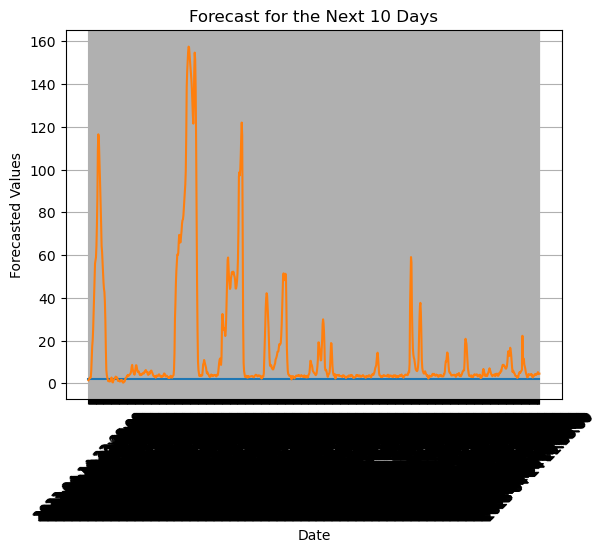

In [30]:
axes = fig.add_axes([0,0,1,1])
plt.plot(pdata['From'],no)
plt.plot(pdata['From'],pm10)
plt.plot(pdata['From'],pm25)
plt.xlabel('Date')
plt.ylabel('Forecasted Values')
plt.title('Forecast for the Next 10 Days')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

RNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_no = scaler.fit_transform(pdata['NO (µg/m3)'].values.reshape(-1, 1))
scaled_pm10 = scaler.fit_transform(pdata['PM10 (µg/m3)'].values.reshape(-1, 1))
scaled_pm25 = scaler.fit_transform(pdata['PM2.5 (µg/m3)'].values.reshape(-1, 1))